# Exploring recipe's cholesterol using two different data sources.

We have cholesterol data from 2 different columns: `nutrition` (nutrition data that has been crawled from a website) and `derived_nutrition` (when not all nutrition data is present in a website, it's is derived/calculated using a machine learning algorithm).

We want to compare the values from both sources.

In [1]:
reset -fs

In [2]:
import datalab.bigquery as bq
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import pprint
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('white')
%matplotlib inline

To be able to see all content columns of a pandas dataframe, we set the width of the columns to max.

In [3]:
pd.set_option('display.max_colwidth', -1)

To be able to see all numeric data with 2 decimals instead of scientific notation.

In [4]:
pd.options.display.float_format = '{:.2f}'.format

To explore the data schema from the table we will extract data.

In [5]:
%bigquery schema --table firebase-wellio:recipes.imported_recipes

Example of a row of data:

```
{"name": "Alcohol, ethyl", "nutrient_id": "221", "unit": "g", "agg_value": 0.0}	 
{"name": "Caffeine", "nutrient_id": "262", "unit": "mg", "agg_value": 0.0}	 
{"name": "Calcium, Ca", "nutrient_id": "301", "unit": "mg", "agg_value": 1313.3905300353488}	 
{"name": "Carbohydrate, by difference", "nutrient_id": "205", "unit": "g", "agg_value": 162.99052465576816}	 
{"name": "Cholesterol", "nutrient_id": "601", "unit": "mg", "agg_value": 375.9498823787561}	 
{"name": "Energy", "nutrient_id": "208", "unit": "kcal", "agg_value": 2333.1553278007873}	 
{"name": "Fatty acids, total monounsaturated", "nutrient_id": "645", "unit": "g", "agg_value": 45.812315539385196}	 
{"name": "Fatty acids, total polyunsaturated", "nutrient_id": "646", "unit": "g", "agg_value": 23.205340564004327}	 
{"name": "Fatty acids, total saturated", "nutrient_id": "606", "unit": "g", "agg_value": 49.405855655327926}	 
{"name": "Fatty acids, total trans", "nutrient_id": "605", "unit": "g", "agg_value": 0.03039770861878195}	 
{"name": "Fiber, total dietary", "nutrient_id": "291", "unit": "g", "agg_value": 30.928357548404282}	 
{"name": "Iron, Fe", "nutrient_id": "303", "unit": "mg", "agg_value": 14.117875369935824}	 
{"name": "Magnesium, Mg", "nutrient_id": "304", "unit": "mg", "agg_value": 323.6146339264634}	 
{"name": "Potassium, K", "nutrient_id": "306", "unit": "mg", "agg_value": 4182.024917283204}	 
{"name": "Protein", "nutrient_id": "203", "unit": "g", "agg_value": 134.36223258379204}	 
{"name": "Sodium, Na", "nutrient_id": "307", "unit": "mg", "agg_value": 3643.3221832455997}	 
{"name": "Sugars, total", "nutrient_id": "269", "unit": "g", "agg_value": 27.08103267541787}	 
{"name": "Total lipid (fat)", "nutrient_id": "204", "unit": "g", "agg_value": 133.7551269233669}	 
{"name": "Vitamin A, IU", "nutrient_id": "318", "unit": "IU", "agg_value": 49854.13482607046}	 
{"name": "Vitamin C, total absorbic acid", "nutrient_id": "401", "unit": "mg", "agg_value": 415.64417814608424}	 
{"name": "Vitamin E (alpha-tocopherol)", "nutrient_id": "323", "unit": "mg", "agg_value": 12.62523061622084}
```

Extracting `derived_nutrition_version`.

In [6]:
%%sql --module derived_nutrition_versions
SELECT
INTEGER(RIGHT(derived_nutrition_version, LENGTH(derived_nutrition_version)-1)) AS nutrition_version
FROM [firebase-wellio:recipes.imported_recipes]
GROUP BY nutrition_version
ORDER BY nutrition_version DESC

In [7]:
%%bigquery execute -q derived_nutrition_versions

nutrition_version
10
9
8
7
6
5
2
""


Latest nutrition version is 10. We will need to specify this version in our BigQuery's to get only the recipes with such attribute and avoid duplicates.

#### Extracting cholesterol from `derived_nutrition` column. Note that we use URLs from domain `epicurious.com` as they always have `derived_nutrition`.

In [8]:
%%sql --module epicurious_cholesterol_derived_nutrition
SELECT url, derived_nutrition AS cholesterol
FROM [firebase-wellio:recipes.imported_recipes]
WHERE url LIKE '%epicurious.com%' AND derived_nutrition IS NOT NULL AND INTEGER(RIGHT(derived_nutrition_version, 
  LENGTH(derived_nutrition_version)-1)) = 10 AND derived_nutrition LIKE '%"name": "Cholesterol"%'

In [9]:
%%bigquery execute -q epicurious_cholesterol_derived_nutrition

url,cholesterol
https://www.epicurious.com/recipes/food/views/classic-shortbread-236614,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 3.280346669839574}"
http://www.epicurious.com/recipes/food/views/roasted-asparagus-365157,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 0.0}"
http://www.epicurious.com/recipes/food/views/chocolate-dipped-spritz-washboards-with-pistachios-387471,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 1.774576560623037}"
http://www.epicurious.com/recipes/food/views/Chocolate-Dipped-Frozen-Banana-Bites-352009,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 14.924024587711942}"
http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 39.73765273399988}"
https://www.epicurious.com/recipes/food/views/corpse-reviver-235963,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 0.0}"
https://www.epicurious.com/recipes/food/views/balsamic-pan-sauce-233411,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 8.494960939383152}"
http://www.epicurious.com/recipes/food/views/parmesan-roasted-butternut-squash-350608,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 121.05557522488652}"
http://www.epicurious.com/recipes/food/views/crisp-roast-duck-235744,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 1903.1521762544312}"
https://www.epicurious.com/recipes/food/views/pickled-quail-eggs-237314,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 68.4614111212819}"


Export data to pandas dataframe.

In [10]:
epicurious_derived_cholesterol_df = bq.Query(epicurious_cholesterol_derived_nutrition).to_dataframe()

How many rows of data?

In [11]:
epicurious_derived_cholesterol_df.shape[0]

654951

In [12]:
epicurious_derived_cholesterol_df.head()

,url,cholesterol
0,https://www.epicurious.com/recipes/food/views/classic-shortbread-236614,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 3.280346669839574}"
1,http://www.epicurious.com/recipes/food/views/roasted-asparagus-365157,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 0.0}"
2,http://www.epicurious.com/recipes/food/views/chocolate-dipped-spritz-washboards-with-pistachios-387471,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 1.774576560623037}"
3,http://www.epicurious.com/recipes/food/views/Chocolate-Dipped-Frozen-Banana-Bites-352009,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 14.924024587711942}"
4,http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 39.73765273399988}"


Extracting numeric value of calories using regex.

In [13]:
epicurious_derived_cholesterol_df['cholesterol_amount'] = epicurious_derived_cholesterol_df['cholesterol'].str.extract('"agg_value": ([0-9]+.[0-9]+)', expand=True)

In [14]:
epicurious_derived_cholesterol_df.head()

,url,cholesterol,cholesterol_amount
0,https://www.epicurious.com/recipes/food/views/classic-shortbread-236614,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 3.280346669839574}",3.280346669839574
1,http://www.epicurious.com/recipes/food/views/roasted-asparagus-365157,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 0.0}",0.0
2,http://www.epicurious.com/recipes/food/views/chocolate-dipped-spritz-washboards-with-pistachios-387471,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 1.774576560623037}",1.774576560623037
3,http://www.epicurious.com/recipes/food/views/Chocolate-Dipped-Frozen-Banana-Bites-352009,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 14.924024587711942}",14.924024587711942
4,http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,"{""name"": ""Cholesterol"", ""nutrient_id"": ""601"", ""unit"": ""mg"", ""agg_value"": 39.73765273399988}",39.73765273399988


Converting new column into float data type.

In [15]:
epicurious_derived_cholesterol_df['cholesterol_amount'] = epicurious_derived_cholesterol_df['cholesterol_amount'].apply(pd.to_numeric)

Exploring basic statistics of the calories amount.

In [16]:
epicurious_derived_cholesterol_df.describe()

,cholesterol_amount
count,654951.00
mean,43642.36
std,2887301.27
min,0.00
25%,131.21
50%,454.98
75%,988.63
max,295343834.25


How many recipes have 0 mg of cholesterol?

In [17]:
epicurious_0_derived_cholesterol_df = epicurious_derived_cholesterol_df[epicurious_derived_cholesterol_df['cholesterol_amount'] == 0]

In [18]:
pd.value_counts(epicurious_0_derived_cholesterol_df['cholesterol_amount'].value_counts())

39882    1
Name: cholesterol_amount, dtype: int64

In [19]:
epicurious_0_derived_cholesterol_df.shape[0]

39882

If we don't filter out extreme cholesterol values, we don't get a very useful histogram or box plot.

Let's create a dataframe with mg of cholesterol greater than 0 and less than 5,000.

In [20]:
epicurious_derived_cholesterol_0_5000_df = epicurious_derived_cholesterol_df[(epicurious_derived_cholesterol_df['cholesterol_amount'] > 0) & (epicurious_derived_cholesterol_df['cholesterol_amount'] < 5000)]

Now, let's visualize a distribution of the cholesterol amount using the new created dataframe.

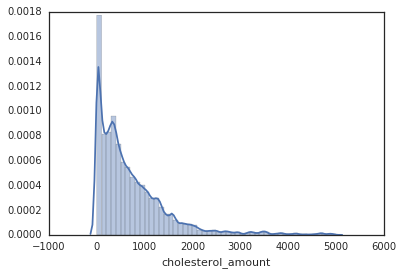

In [21]:
sns.distplot(epicurious_derived_cholesterol_0_5000_df['cholesterol_amount']);

And the box plot.

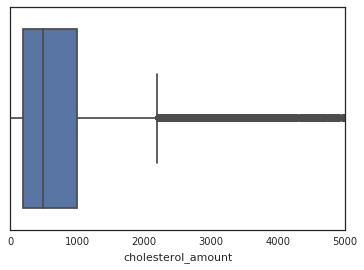

In [22]:
sns.boxplot(x=epicurious_derived_cholesterol_0_5000_df['cholesterol_amount']);

We see many outliers with recipes with more than 2,000 mg of cholesterol.

#### Extracting calories from `nutrition` column. Note that we use URLs from domain `epicurious.com` as they always have `nutrition`.

One row of data looks like:

```
Calories 830.5	 
Calories from Fat 235	 
Total Fat 26.2 g	 
Saturated Fat 8.3 g	 
Cholesterol 75.1 mg	 
Sodium 1251.3 mg	 
Total Carbohydrate 103.2 g	 
Dietary Fiber 5.4 g	 
Sugars 5.3 g	 
Protein 43 g
```

In [23]:
%%sql --module epicurious_cholesterol_nutrition
SELECT url, nutrition AS cholesterol, RIGHT(nutrition, LENGTH(nutrition)-LENGTH('Cholesterol'))AS cholesterol_extract
FROM FLATTEN([firebase-wellio:recipes.imported_recipes], nutrition)
WHERE url LIKE '%epicurious.com%' AND derived_nutrition IS NOT NULL AND INTEGER(RIGHT(derived_nutrition_version, 
  LENGTH(derived_nutrition_version)-1)) = 10 AND nutrition LIKE 'Cholesterol%'

In [24]:
%%bigquery execute -q epicurious_cholesterol_nutrition

url,cholesterol,cholesterol_extract
http://www.epicurious.com/recipes/food/views/seared-duck-breast-with-cherries-and-port-sauce-353376,Cholesterol 151 mg(50%),151 mg(50%)
http://www.epicurious.com/recipes/food/views/seven-layer-salmon-bites-236713,Cholesterol 12 mg(4%),12 mg(4%)
http://www.epicurious.com/recipes/food/views/ultimate-mud-pie-365111,Cholesterol 169 mg(56%),169 mg(56%)
http://www.epicurious.com/recipes/food/views/beef-and-guinness-pie-230754,Cholesterol 189 mg(63%),189 mg(63%)
http://www.epicurious.com/recipes/food/views/beef-and-guinness-pie-230754,Cholesterol 189 mg(63%),189 mg(63%)
http://www.epicurious.com/recipes/food/views/french-yogurt-cake-395471,Cholesterol 50 mg(17%),50 mg(17%)
http://www.epicurious.com/recipes/food/views/trios-240930,Cholesterol 48 mg(16%),48 mg(16%)
http://www.epicurious.com/recipes/food/views/homemade-cheese-with-garlic-and-herbs,Cholesterol 52 mg(17%),52 mg(17%)
http://www.epicurious.com/recipes/food/views/black-sesame-noodle-bowl,Cholesterol 93 mg(31%),93 mg(31%)
http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,Cholesterol 18 mg(6%),18 mg(6%)


Export to pandas dataframe.

In [25]:
epicurious_cholesterol_df = bq.Query(epicurious_cholesterol_nutrition).to_dataframe()

Note. In case we want to perform sampling with BigQuery:
https://www.oreilly.com/learning/repeatable-sampling-of-data-sets-in-bigquery-for-machine-learning

In [26]:
epicurious_cholesterol_df.head()

,url,cholesterol,cholesterol_extract
0,http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,Cholesterol 18 mg(6%),18 mg(6%)
1,http://www.epicurious.com/recipes/food/views/parmesan-roasted-butternut-squash-350608,Cholesterol 22 mg(7%),22 mg(7%)
2,http://www.epicurious.com/recipes/food/views/crisp-roast-duck-235744,Cholesterol 474 mg(158%),474 mg(158%)
3,http://www.epicurious.com/recipes/food/views/bearnaise-sauce-395049,Cholesterol 111 mg(37%),111 mg(37%)
4,http://www.epicurious.com/recipes/food/views/poblano-potato-gratin-350596,Cholesterol 33 mg(11%),33 mg(11%)


How many rows of data?

In [27]:
epicurious_cholesterol_df.shape[0]

294456

Using regex to obtain the cholesterol amount.

In [28]:
epicurious_cholesterol_df['cholesterol_amount'] = epicurious_cholesterol_df['cholesterol_extract'].str.extract('([0-9]+)', expand=True)

In [29]:
epicurious_cholesterol_df.head()

,url,cholesterol,cholesterol_extract,cholesterol_amount
0,http://www.epicurious.com/recipes/food/views/pasta-with-tomatoes-and-goat-cheese-103833,Cholesterol 18 mg(6%),18 mg(6%),18
1,http://www.epicurious.com/recipes/food/views/parmesan-roasted-butternut-squash-350608,Cholesterol 22 mg(7%),22 mg(7%),22
2,http://www.epicurious.com/recipes/food/views/crisp-roast-duck-235744,Cholesterol 474 mg(158%),474 mg(158%),474
3,http://www.epicurious.com/recipes/food/views/bearnaise-sauce-395049,Cholesterol 111 mg(37%),111 mg(37%),111
4,http://www.epicurious.com/recipes/food/views/poblano-potato-gratin-350596,Cholesterol 33 mg(11%),33 mg(11%),33


Converting cholesterol amount into float data type.

In [30]:
epicurious_cholesterol_df['cholesterol_amount'] = epicurious_cholesterol_df['cholesterol_amount'].apply(pd.to_numeric)

Let's check the columns data types.

In [31]:
epicurious_cholesterol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294456 entries, 0 to 294455
Data columns (total 4 columns):
url                    294456 non-null object
cholesterol            294456 non-null object
cholesterol_extract    294456 non-null object
cholesterol_amount     294456 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.0+ MB


Checking basic statistics of the cholesterol amount.

In [32]:
epicurious_cholesterol_df.cholesterol_amount.describe()

count   294456.00
mean    132.27   
std     174.38   
min     0.00     
25%     49.00    
50%     86.00    
75%     160.00   
max     4639.00  
Name: cholesterol_amount, dtype: float64

If we don't filter out extreme cholesterol values, we don't get a very useful histogram.

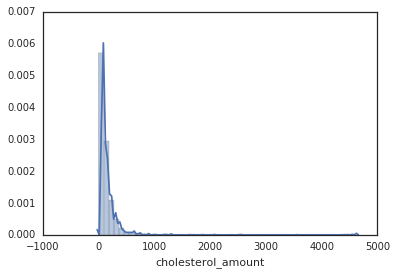

In [33]:
sns.distplot(epicurious_cholesterol_df['cholesterol_amount']);

And a box plot.

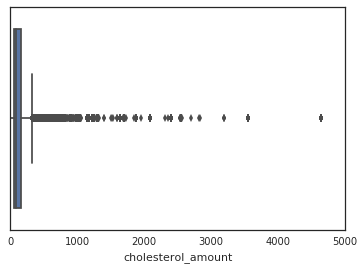

In [34]:
sns.boxplot(x=epicurious_cholesterol_df['cholesterol_amount']);

Creating a dataframe with recipes with more than 0 mg of cholesterol and less than a 5,000 mg of cholesterol.

In [35]:
epicurious_cholesterol_0_5000_df = epicurious_cholesterol_df[(epicurious_cholesterol_df['cholesterol_amount'] > 0) & (epicurious_cholesterol_df['cholesterol_amount'] < 5000)]

And it's corresponding distribution plot.

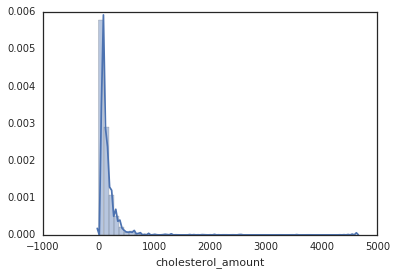

In [36]:
sns.distplot(epicurious_cholesterol_0_5000_df['cholesterol_amount']);

Box plot.

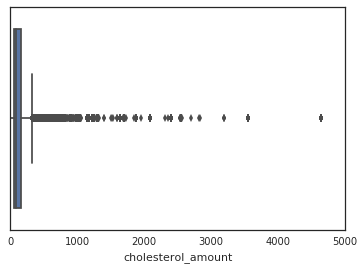

In [37]:
sns.boxplot(x=epicurious_cholesterol_0_5000_df['cholesterol_amount']);

We can see many outliers for recipes with more than ~400 mg of cholesterol.

### We can see that the cholesterol distribution is more extreme when using derived_nutrition compared to nutrition, and that where using nutrition, most of the recipes have a cholesterol amount around 100 mg.